
# Summary of the Content
1. **Define the Problem:** 
Predict whether the customer will purchase again in the next 12 month after the first purchase completed.

2. **Gather the Data:** 
Get the raw from a ecommerce store via BigQuery tabales

3. **Prepare Data for Consumption:** 
*   (1) Calculate 12 month purchase frequency and CLV
*   (2) Clean-up
*   (3) Handling missing data


4. **Perform Exploratory Analysis:** 

*   (1) Basic descriptive statistics: min, mean, median, quantiles, max
*   (2) Check distributions
*   (3) Correlations

Imbalanced classifiction problem

5. **Feature Engineering**

*   (1) Creating dummy variables for: binary features and low cardinal categorical features
*   (2) Target encoding for high cardinal categorical features

6. **Modeling and hyperparameter tunning :** 

-   Logistic Regression
-   Decision Tree
-   RandomForest

- Grid search_cv 

7. **Evaluation and model selection :** 




8. **Optimize and Strategize:** 



## 3.Prepare Data for Consumption:

In [1]:
import os
import glob
import datetime 
import pandas as pd
import numpy as np
import sys

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn import preprocessing
!pip install category_encoders
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.model_selection import ParameterGrid

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import export_graphviz
import graphviz
from graphviz import Source

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

In [2]:
# find the unique values in each column
def unique_counts(customer):
    for i in customer.columns:
        count=customer[i].nunique()
        print(i, ':', count)
        

#print missing value table
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values ', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns 


In [3]:
#upload the csv file to colab generated from 'Gather the data' Process
from google.colab import files
uploaded = files.upload()


Saving clv_file.csv to clv_file (4).csv


In [43]:
customers = pd.read_csv('clv_file (4).csv')
customers.shape

(536811, 26)

In [44]:
customers.head()

,uid,buyer_accepts_marketing,order_date,order_id,order_revenue,total_discounts,landing_site,landing_site_ref,referring_site,tags,utm_campaign,utm_source,utm_medium,utm_term,utm_content,first_order_date,SP,DD,AE,country_code,province_code,requires_shipping,item_qty,unique_item,revenue_12m,order_count_12m
0,-1.600000e+18,False,7/31/16,3.639006e+09,20.0,0.0,/,NaN,http://www.I4.com/,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-31,NaN,NaN,NaN,US,MA,False,1,1,20.0,1
1,-5.490000e+18,True,7/31/16,3.638473e+09,20.0,0.0,/,NaN,http://www.wykss.com/,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-31,NaN,NaN,NaN,US,OH,False,1,1,20.0,1
2,3.840000e+18,False,7/31/16,3.633415e+09,20.0,0.0,/,NaN,http://shop.wykss.com/,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-31,NaN,NaN,NaN,US,OH,False,1,1,20.0,1
3,2.380000e+18,True,7/31/16,3.636015e+09,20.0,0.0,/,NaN,http://shop.wykss.com/,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-31,NaN,NaN,NaN,US,NY,False,1,1,20.0,1
4,-6.390000e+18,False,7/31/16,3.636490e+09,20.0,0.0,/,NaN,http://www.wykss.com/,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-31,NaN,Y,Y,US,WI,False,1,1,20.0,1


In [45]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536811 entries, 0 to 536810
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   uid                      536811 non-null  float64
 1   buyer_accepts_marketing  536811 non-null  bool   
 2   order_date               536811 non-null  object 
 3   order_id                 536811 non-null  float64
 4   order_revenue            536811 non-null  float64
 5   total_discounts          536811 non-null  float64
 6   landing_site             534257 non-null  object 
 7   landing_site_ref         2 non-null       object 
 8   referring_site           354646 non-null  object 
 9   tags                     2457 non-null    object 
 10  utm_campaign             53205 non-null   object 
 11  utm_source               53393 non-null   object 
 12  utm_medium               53335 non-null   object 
 13  utm_term                 21700 non-null   object 
 14  utm_

In [46]:
customers.describe()

,uid,order_id,order_revenue,total_discounts,item_qty,unique_item,revenue_12m,order_count_12m
count,5.368110e+05,5.368110e+05,536811.000000,536811.000000,536811.000000,536811.0,536811.000000,536811.000000
mean,1.612341e+15,8.566186e+11,67.198656,0.161512,1.033027,1.0,95.900871,1.383612
std,5.322875e+18,6.084956e+11,81.282303,2.593883,0.274625,0.0,190.260530,0.920181
min,-9.220000e+18,3.633358e+09,0.000000,0.000000,1.000000,1.0,0.000000,1.000000
25%,-4.600000e+18,5.170000e+11,25.000000,0.000000,1.000000,1.0,30.000000,1.000000
50%,2.240000e+15,5.600000e+11,50.000000,0.000000,1.000000,1.0,65.000000,1.000000
75%,4.610000e+18,1.710000e+12,85.000000,0.000000,1.000000,1.0,105.000000,1.000000
max,9.220000e+18,2.430000e+12,21210.000000,1275.000000,50.000000,1.0,51030.000000,37.000000


In [47]:
# check categorical variables
for i in customers.columns:
    if customers[i].dtypes == 'O':
        print(i, ': ', customers[i].nunique())

order_date :  1394
landing_site :  46463
landing_site_ref :  2
referring_site :  22899
tags :  2
utm_campaign :  87
utm_source :  44
utm_medium :  12
utm_term :  21019
utm_content :  18
first_order_date :  1394
SP :  1
DD :  1
AE :  1
country_code :  158
province_code :  516


In [48]:
missing_values_table(customers)

Your selected dataframe has 26 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
landing_site_ref,536809,100.0
utm_content,536232,99.9
tags,534354,99.5
SP,525880,98.0
utm_term,515111,96.0
AE,509900,95.0
utm_campaign,483606,90.1
utm_medium,483476,90.1
utm_source,483418,90.1
DD,376288,70.1


In [49]:
# drop customers with first order < =0
customers = customers[customers['order_revenue'] > 0]
customers.shape

(532565, 26)

### Formatting

In [50]:
customers.rename(columns={'order_revenue':
                   'first_order_revenue',
                  'total_discounts':
                   'first_order_discount' }, inplace= True)
customers['revenue_12m']=customers['revenue_12m'].astype(float)
customers['first_order_discount']=customers['first_order_discount'].astype(float)
customers['first_order_revenue']=customers['first_order_revenue'].astype(float)

# add new day_of_week column
customers['order_date']=pd.to_datetime(customers['order_date'])
customers['day_of_week']=customers['order_date'].dt.dayofweek 
customers['day_of_week'] =customers['day_of_week'].astype(str)


# create target column repeat_purchase
# customers['repeat_purchase'] = ~(customers.order_count_12m < 2)
customers['repeat_purchase'] = np.where(customers.order_count_12m >1,  1, 0)

### Handling missing values
(1) filling null based on business definitions

In [51]:
customers['province_code'].fillna("unknown", inplace = True) 
customers['country_code'].fillna("unknown", inplace = True) 

cols_to_fill = ['utm_content','landing_site','utm_term','utm_campaign', 'utm_medium','utm_source', 'referring_site', 'AE', 'DD', 'SP']
for i in cols_to_fill:
  customers[i+'_known'] = customers[i].notnull()

cols_to_drop=['landing_site_ref','tags', 'utm_term','utm_content','landing_site',
         'utm_campaign','utm_medium','utm_source','referring_site','AE', 'DD', 'SP']
customers.drop(cols_to_drop, axis=1, inplace=True)

In [52]:
#check missing value again
missing_values_table(customers)

Your selected dataframe has 26 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [53]:
unique_counts(customers)

uid : 5619
buyer_accepts_marketing : 2
order_date : 1394
order_id : 49492
first_order_revenue : 858
first_order_discount : 139
first_order_date : 1394
country_code : 159
province_code : 517
requires_shipping : 2
item_qty : 21
unique_item : 1
revenue_12m : 3228
order_count_12m : 27
day_of_week : 7
repeat_purchase : 2
utm_content_known : 2
landing_site_known : 2
utm_term_known : 2
utm_campaign_known : 2
utm_medium_known : 2
utm_source_known : 2
referring_site_known : 2
AE_known : 2
DD_known : 2
SP_known : 2


In [54]:
for column in customers:
    unique_values = np.unique(customers[column])
    nr_values = len(unique_values)
    if nr_values <= 10:
        print("The number of values for feature {} is: {} -- {}".format(column, nr_values, unique_values))
    else:
        print("The number of values for feature {} is: {}".format(column, nr_values))

The number of values for feature uid is: 5619
The number of values for feature buyer_accepts_marketing is: 2 -- [False  True]
The number of values for feature order_date is: 1394
The number of values for feature order_id is: 49492
The number of values for feature first_order_revenue is: 858
The number of values for feature first_order_discount is: 139
The number of values for feature first_order_date is: 1394
The number of values for feature country_code is: 159
The number of values for feature province_code is: 517
The number of values for feature requires_shipping is: 2 -- [False  True]
The number of values for feature item_qty is: 21
The number of values for feature unique_item is: 1 -- [1]
The number of values for feature revenue_12m is: 3228
The number of values for feature order_count_12m is: 27
The number of values for feature day_of_week is: 7 -- ['0' '1' '2' '3' '4' '5' '6']
The number of values for feature repeat_purchase is: 2 -- [0 1]
The number of values for feature utm_co

In [55]:
customers.shape

(532565, 26)

In [56]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532565 entries, 0 to 536810
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   uid                      532565 non-null  float64       
 1   buyer_accepts_marketing  532565 non-null  bool          
 2   order_date               532565 non-null  datetime64[ns]
 3   order_id                 532565 non-null  float64       
 4   first_order_revenue      532565 non-null  float64       
 5   first_order_discount     532565 non-null  float64       
 6   first_order_date         532565 non-null  object        
 7   country_code             532565 non-null  object        
 8   province_code            532565 non-null  object        
 9   requires_shipping        532565 non-null  bool          
 10  item_qty                 532565 non-null  int64         
 11  unique_item              532565 non-null  int64         
 12  revenue_12m     

In [57]:
customers.describe()

,uid,order_id,first_order_revenue,first_order_discount,item_qty,unique_item,revenue_12m,order_count_12m,repeat_purchase
count,5.325650e+05,5.325650e+05,532565.000000,532565.000000,532565.000000,532565.0,532565.000000,532565.000000,532565.000000
mean,7.763938e+14,8.554080e+11,67.734413,0.094273,1.033277,1.0,96.623003,1.385964,0.233639
std,5.323107e+18,6.055553e+11,81.383033,1.240837,0.275652,0.0,190.817455,0.922873,0.423146
min,-9.220000e+18,3.633358e+09,0.690000,0.000000,1.000000,1.0,0.690000,1.000000,0.000000
25%,-4.600000e+18,5.220000e+11,25.000000,0.000000,1.000000,1.0,35.000000,1.000000,0.000000
50%,1.270000e+15,5.600000e+11,50.000000,0.000000,1.000000,1.0,65.000000,1.000000,0.000000
75%,4.610000e+18,1.710000e+12,85.000000,0.000000,1.000000,1.0,105.000000,1.000000,0.000000
max,9.220000e+18,2.430000e+12,21210.000000,99.900000,50.000000,1.0,51030.000000,37.000000,1.000000


### Check the distribution

(<matplotlib.axes._subplots.AxesSubplot at 0x7f48cb66f2b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f48cb63cb38>)

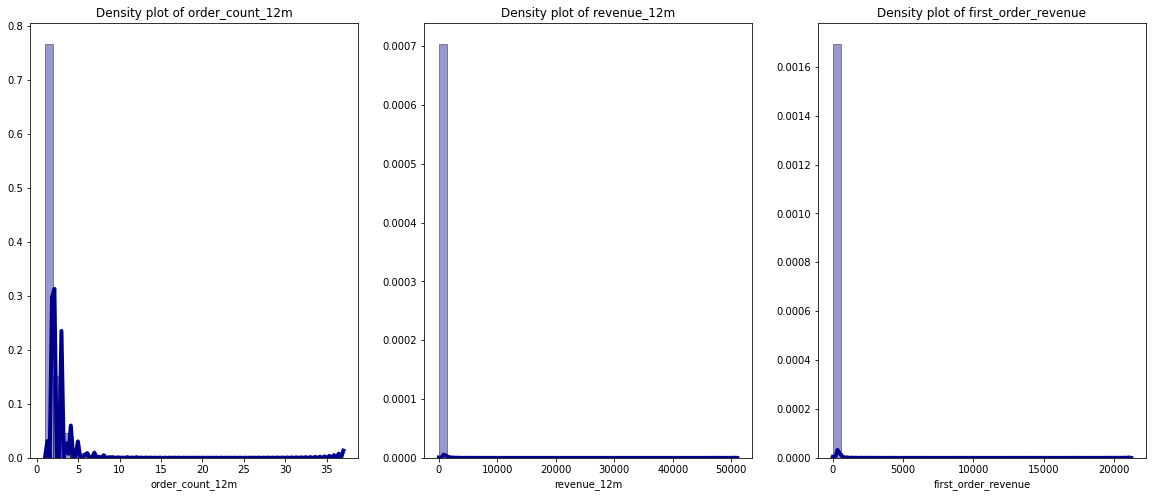

In [58]:
def density3(df1, df2,df3):
  #input shape df['col']
  fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20,8))
  g1=sns.distplot(df1, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0])
  axes[0].set_title('Density plot of order_count_12m')

  g2=sns.distplot(df2, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},ax=axes[1])
  axes[1].set_title('Density plot of revenue_12m')

  g3=sns.distplot(df3, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},ax=axes[2])
  axes[2].set_title('Density plot of first_order_revenue')

  return g1, g2, g3

density3(customers['order_count_12m'], 
         customers['revenue_12m'],
         customers['first_order_revenue'])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f48cb45b710>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f48cb3fcb00>)

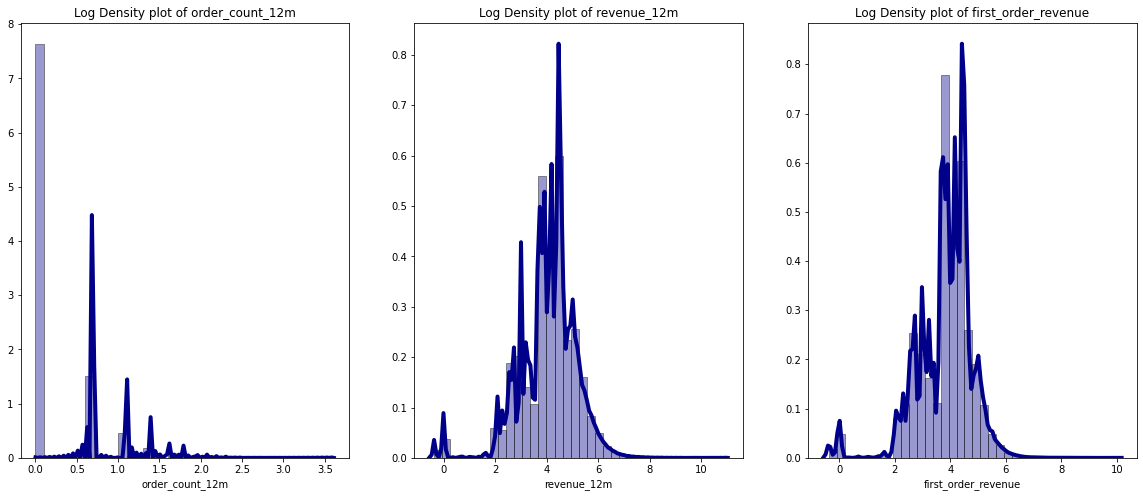

In [59]:
def density4(df1, df2,df3):
  #input shape df['col']
  fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20,8))
  g1=sns.distplot(df1, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0])
  axes[0].set_title('Log Density plot of order_count_12m')

  g2=sns.distplot(df2, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},ax=axes[1])
  axes[1].set_title('Log Density plot of revenue_12m')

  g3=sns.distplot(df3, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},ax=axes[2])
  axes[2].set_title('Log Density plot of first_order_revenue')

  return g1, g2, g3

density4(np.log(customers['order_count_12m']), np.log(customers['revenue_12m']),np.log(customers['first_order_revenue'])
         )

(<matplotlib.axes._subplots.AxesSubplot at 0x7f48d43e2550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f48cb1d4710>)

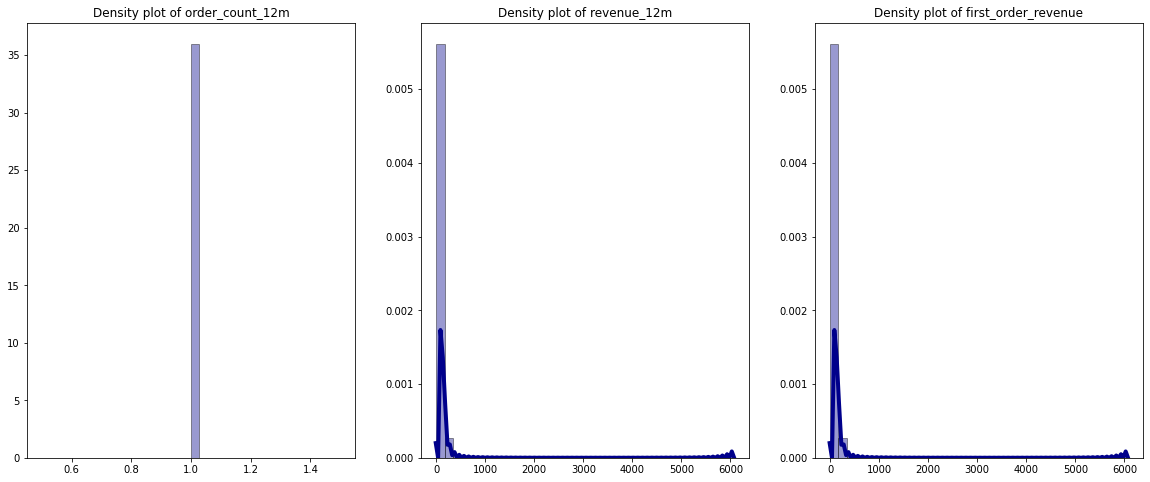

In [60]:
density3(customers.loc[customers['repeat_purchase']==0,['order_count_12m']], 
         customers.loc[customers['repeat_purchase']==0,['revenue_12m']],
         customers.loc[customers['repeat_purchase']==0,['first_order_revenue']])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f48d43e2470>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f48cb27f048>)

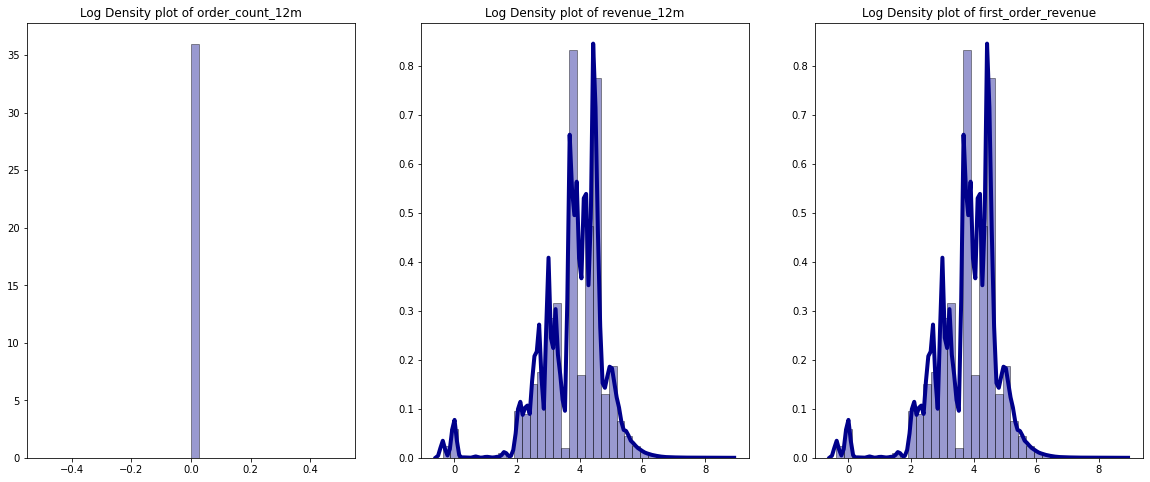

In [61]:
density4(np.log(customers.loc[customers['repeat_purchase']==0,['order_count_12m']]), 
         np.log(customers.loc[customers['repeat_purchase']==0,['revenue_12m']]),
         np.log(customers.loc[customers['repeat_purchase']==0,['first_order_revenue']])
         )

(<matplotlib.axes._subplots.AxesSubplot at 0x7f48cadae6a0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f48cad28c18>)

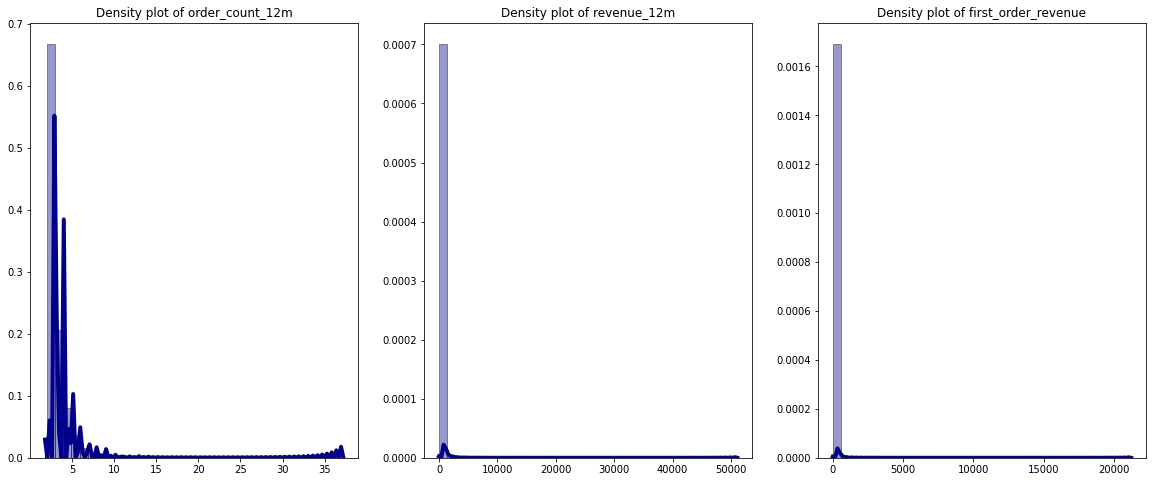

In [62]:
density3(customers.loc[customers['repeat_purchase']==1,['order_count_12m']], 
         customers.loc[customers['repeat_purchase']==1,['revenue_12m']],
         customers.loc[customers['repeat_purchase']==1,['first_order_revenue']])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f48cab2acf8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f48caafa518>)

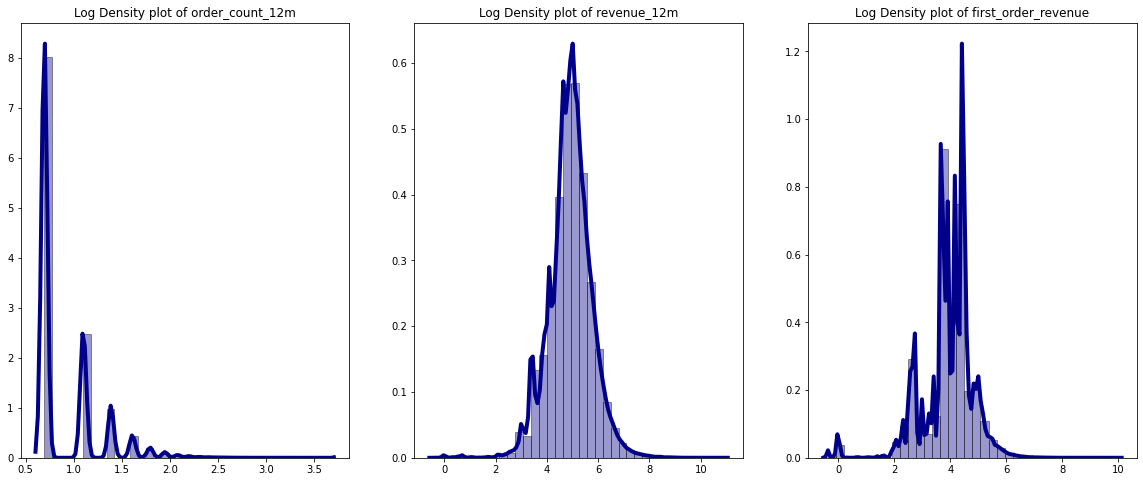

In [63]:
density4(np.log(customers.loc[customers['repeat_purchase']==1,['order_count_12m']]), 
         np.log(customers.loc[customers['repeat_purchase']==1,['revenue_12m']]),
         np.log(customers.loc[customers['repeat_purchase']==1,['first_order_revenue']])
                )

### Compare one-time customers and repeat customers in one graph

In [64]:
df2 = customers[['order_count_12m','revenue_12m','first_order_revenue','repeat_purchase']]
for i in df2.drop('repeat_purchase', axis=1).columns:
    df2['log_{0}'.format(i)] = np.log(customers[i])
df2.columns

Index(['order_count_12m', 'revenue_12m', 'first_order_revenue',
       'repeat_purchase', 'log_order_count_12m', 'log_revenue_12m',
       'log_first_order_revenue'],
      dtype='object')

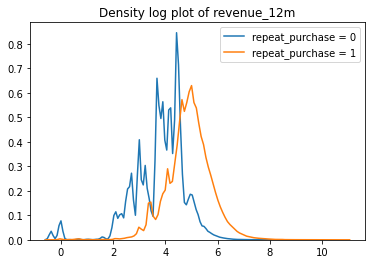

In [65]:
# Sort the dataframe by target variable
repeat_0 = df2.loc[df2['repeat_purchase'] == 0]
repeat_1 = df2.loc[df2['repeat_purchase'] == 1]

sns.distplot(repeat_0[['log_revenue_12m']], hist=False,label='repeat_purchase = 0')
sns.distplot(repeat_1[['log_revenue_12m']], hist=False,label='repeat_purchase = 1')
plt.title('Density log plot of revenue_12m')
plt.legend()

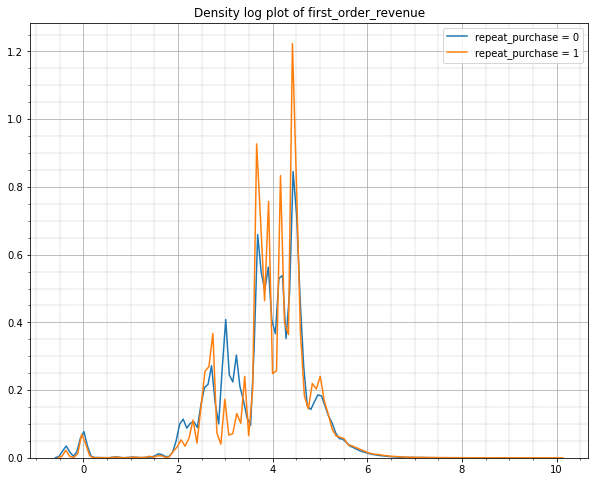

In [66]:
# plot first purchase 
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 8))

sns.distplot(repeat_0[['log_first_order_revenue']], hist=False,label='repeat_purchase = 0')
sns.distplot(repeat_1[['log_first_order_revenue']], hist=False,label='repeat_purchase = 1')
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.25', color='black')

plt.title('Density log plot of first_order_revenue')
plt.legend()
plt.grid(True)

Interesgting, this show the difference between single purchaser and repeat purchasers with x-axis number roughly between 2.9-3.4. Features can be created to extract this information. 

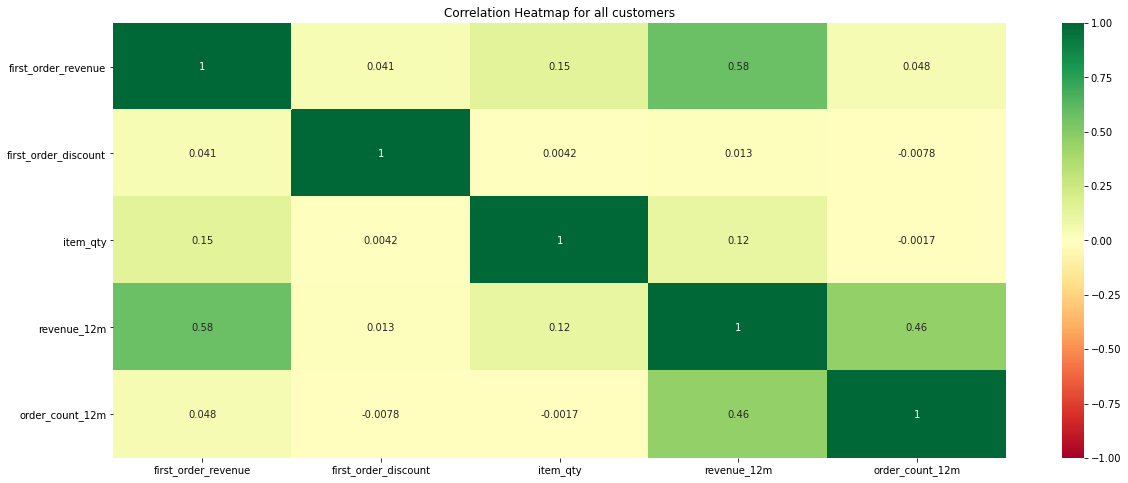

In [67]:
corr = customers[['first_order_revenue','first_order_discount','item_qty','revenue_12m','order_count_12m']].corr()
# fig, axes = plt.subplots(1, 2,figsize=(20,8))
# sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1,ax=axes[0])  
# axes[0].title.set_text('Correlation Heatmap for all purchasers ')

fig, ax= plt.subplots(figsize=(20, 8))
ax = sns.heatmap(corr, annot= True, cmap='RdYlGn', vmin=-1, vmax=1)
ax.title.set_text('Correlation Heatmap for all customers')

## 5.Feature Engineering

*   (1) Add new feature to represent log(first_purchase) between 2.9-3.4 or not from EDA
*   (2) Create dummy variables for: binary features and low cardinal categorical features
*   (3) Target encoding for high cardinal categorical features

In [68]:
# all customer age > = 12month
df_customer=customers.copy()
df_customer=df_customer[df_customer.first_order_date < '2019-05-01']
df_customer.shape

(378075, 26)

### Add new feature - log_first_range
log_first_range (Y/N) to represent whether log( first_purchase_revenue) between 2.9 to 3.4 or not

In [69]:
df_customer['log_first_range'] = df_customer.apply(lambda x: 'True' if (np.log(x.first_order_revenue) >2.9) & (np.log(x.first_order_revenue) <3.4) else 'False', axis=1)


In [70]:
df_customer.head()

,uid,buyer_accepts_marketing,order_date,order_id,first_order_revenue,first_order_discount,first_order_date,country_code,province_code,requires_shipping,item_qty,unique_item,revenue_12m,order_count_12m,day_of_week,repeat_purchase,utm_content_known,landing_site_known,utm_term_known,utm_campaign_known,utm_medium_known,utm_source_known,referring_site_known,AE_known,DD_known,SP_known,log_first_range
0,-1.600000e+18,False,2016-07-31,3.639006e+09,20.0,0.0,2016-07-31,US,MA,False,1,1,20.0,1,6,0,False,True,False,False,False,False,True,False,False,False,True
1,-5.490000e+18,True,2016-07-31,3.638473e+09,20.0,0.0,2016-07-31,US,OH,False,1,1,20.0,1,6,0,False,True,False,False,False,False,True,False,False,False,True
2,3.840000e+18,False,2016-07-31,3.633415e+09,20.0,0.0,2016-07-31,US,OH,False,1,1,20.0,1,6,0,False,True,False,False,False,False,True,False,False,False,True
3,2.380000e+18,True,2016-07-31,3.636015e+09,20.0,0.0,2016-07-31,US,NY,False,1,1,20.0,1,6,0,False,True,False,False,False,False,True,False,False,False,True
4,-6.390000e+18,False,2016-07-31,3.636490e+09,20.0,0.0,2016-07-31,US,WI,False,1,1,20.0,1,6,0,False,True,False,False,False,False,True,True,True,False,True


In [73]:
### Train - test split
train = df_customer[df_customer.first_order_date < '2018-10-31']
test  = df_customer[df_customer.first_order_date > '2018-10-31']
train.drop(columns=['uid','order_date','order_id','first_order_date','revenue_12m','order_count_12m'], inplace= True)
test.drop(columns=['uid','order_date','order_id','first_order_date','revenue_12m','order_count_12m'], inplace= True)
train.shape, test.shape

((351858, 21), (26187, 21))

In [74]:
train.columns

Index(['buyer_accepts_marketing', 'first_order_revenue',
       'first_order_discount', 'country_code', 'province_code',
       'requires_shipping', 'item_qty', 'unique_item', 'day_of_week',
       'repeat_purchase', 'utm_content_known', 'landing_site_known',
       'utm_term_known', 'utm_campaign_known', 'utm_medium_known',
       'utm_source_known', 'referring_site_known', 'AE_known', 'DD_known',
       'SP_known', 'log_first_range'],
      dtype='object')

In [75]:
train.groupby('repeat_purchase').size()

repeat_purchase
0    258539
1     93319
dtype: int64

In [76]:
test.groupby('repeat_purchase').size()

repeat_purchase
0    21430
1     4757
dtype: int64

### Target Encoding

In [77]:
from category_encoders import TargetEncoder
encoder = TargetEncoder()
train['country_code_encoded'] = encoder.fit_transform(train['country_code'], train['repeat_purchase'])
test['country_code_encoded'] = encoder.fit_transform(test['country_code'], test['repeat_purchase'])
train.drop(columns=['country_code','province_code'], inplace= True)
test.drop(columns=['country_code','province_code'], inplace= True)


In [78]:
train.shape, test.shape

((351858, 20), (26187, 20))

### Dummy variables

In [89]:
X_train= train.drop(columns='repeat_purchase')
X_train= pd.get_dummies(X_train)

X_test= test.drop(columns='repeat_purchase')
X_test= pd.get_dummies(X_test)
print(X_train.shape, X_test.shape)

(351858, 26) (26187, 26)


In [90]:
y_test  = np.array(test['repeat_purchase'])
y_train =  np.array(train['repeat_purchase'])
# Convert to numpy array
features_train = np.array(X_train)
features_test = np.array(X_test)

## 6.Modeling and hyperparameter tunning via grid search

###LogisticRegression

In [117]:
model = LogisticRegression(random_state=42,class_weight='balanced')
param_grid = {'solver': ['liblinear'],  #'lbfgs'
              'penalty': ['l2','l1'], 
              'C': [0.0002, 0.0005,0.0008, 0.000010]
             }

feat1= []
feat2 = []
feat3 =[]
f1 = []
test_f1=[]
train_f1=[]


for params in ParameterGrid(param_grid):
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_test_pred=model.predict(X_test)
    y_train_pred= model.predict(X_train)
    test_f1_score=metrics.f1_score(y_test, y_test_pred)
    train_f1_score=metrics.f1_score(y_train, y_train_pred)
    feat1.append(params['solver'])
    feat2.append(params['penalty'])
    feat3.append(params['C'])
    test_f1.append(test_f1_score)
    train_f1.append(train_f1_score)
    f1.append(test_f1)
    print(params, test_f1_score, train_f1_score)

{'C': 0.0002, 'penalty': 'l2', 'solver': 'liblinear'} 0.3426622917068777 0.4598774656306037
{'C': 0.0002, 'penalty': 'l1', 'solver': 'liblinear'} 0.3594800537875392 0.4300736192899262
{'C': 0.0005, 'penalty': 'l2', 'solver': 'liblinear'} 0.3361673414304993 0.4600846717189709
{'C': 0.0005, 'penalty': 'l1', 'solver': 'liblinear'} 0.3622280441963777 0.45088211708099435
{'C': 0.0008, 'penalty': 'l2', 'solver': 'liblinear'} 0.33684355427076884 0.4603446265417354
{'C': 0.0008, 'penalty': 'l1', 'solver': 'liblinear'} 0.3384149758995628 0.4611736544862925
{'C': 1e-05, 'penalty': 'l2', 'solver': 'liblinear'} 0.35346989966555187 0.43783899620176464
{'C': 1e-05, 'penalty': 'l1', 'solver': 'liblinear'} 0.30745863495346437 0.4192444802853696


In [92]:
hp1 = pd.DataFrame({'solver': feat1, 'penalty': feat2, 'C': feat3,'test_f1_score':test_f1, 'train_f1_score':train_f1})
hp1

,solver,penalty,C,test_f1_score,train_f1_score
0,liblinear,l2,0.00020,0.342662,0.459877
1,liblinear,l1,0.00020,0.359480,0.430074
2,liblinear,l2,0.00050,0.336167,0.460085
3,liblinear,l1,0.00050,0.362228,0.450882
4,liblinear,l2,0.00080,0.336844,0.460345
5,liblinear,l1,0.00080,0.338415,0.461174
6,liblinear,l2,0.00001,0.353470,0.437839
7,liblinear,l1,0.00001,0.307459,0.419244


In [124]:
model = LogisticRegression(random_state=42,class_weight='balanced')
param_grid = {'solver': ['lbfgs'],  #'lbfgs'
              'penalty': ['l2'], 
              'C': [0.0002, 0.0005,0.0008, 0.000010]
             }                   	
feat1= []
feat2 = []
feat3 =[]
f1 = []
test_f1=[]
train_f1=[]


for params in ParameterGrid(param_grid):
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_test_pred=model.predict(X_test)
    y_train_pred= model.predict(X_train)
    test_f1_score=metrics.f1_score(y_test, y_test_pred)
    train_f1_score=metrics.f1_score(y_train, y_train_pred)
    feat1.append(params['solver'])
    feat2.append(params['penalty'])
    feat3.append(params['C'])
    test_f1.append(test_f1_score)
    train_f1.append(train_f1_score)
    f1.append(test_f1)
    print(params, test_f1_score, train_f1_score)

{'C': 0.0002, 'penalty': 'l2', 'solver': 'lbfgs'} 0.3395061728395061 0.4601372557853164
{'C': 0.0005, 'penalty': 'l2', 'solver': 'lbfgs'} 0.33317441939658105 0.4601523613762785
{'C': 0.0008, 'penalty': 'l2', 'solver': 'lbfgs'} 0.33703065794006204 0.4606345740430178
{'C': 1e-05, 'penalty': 'l2', 'solver': 'lbfgs'} 0.3599701269604182 0.4325596987580787


In [125]:
hp2 = pd.DataFrame({'solver': feat1, 'penalty': feat2, 'C': feat3,'test_f1_score':test_f1, 'train_f1_score':train_f1})
hp2

,solver,penalty,C,test_f1_score,train_f1_score
0,lbfgs,l2,0.00020,0.339506,0.460137
1,lbfgs,l2,0.00050,0.333174,0.460152
2,lbfgs,l2,0.00080,0.337031,0.460635
3,lbfgs,l2,0.00001,0.359970,0.432560


In [95]:
hp=pd.concat([hp1, hp2], axis=0)
hp['classifier']='LogisticRegression'
hp

,solver,penalty,C,test_f1_score,train_f1_score,classifier
0,liblinear,l2,0.00020,0.342662,0.459877,LogisticRegression
1,liblinear,l1,0.00020,0.359480,0.430074,LogisticRegression
2,liblinear,l2,0.00050,0.336167,0.460085,LogisticRegression
3,liblinear,l1,0.00050,0.362228,0.450882,LogisticRegression
4,liblinear,l2,0.00080,0.336844,0.460345,LogisticRegression
5,liblinear,l1,0.00080,0.338415,0.461174,LogisticRegression
6,liblinear,l2,0.00001,0.353470,0.437839,LogisticRegression
7,liblinear,l1,0.00001,0.307459,0.419244,LogisticRegression
0,lbfgs,l2,0.00020,0.339506,0.460137,LogisticRegression
1,lbfgs,l2,0.00050,0.333174,0.460152,LogisticRegression


In [96]:
hp.test_f1_score.max()

0.3622280441963777

### DecisionTree

In [97]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
clf = DecisionTreeClassifier()
print(clf)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [98]:
model = DecisionTreeClassifier(random_state=42,class_weight="balanced")
param_grid = {'criterion': ['gini','entropy'], 
              'splitter': ['best', 'random'], 
              'max_depth': [2,3,4], 
              'min_samples_split': [5, 50], 
              'min_samples_leaf': [2,10,15]
             }
feat1= []
feat2 = []
feat3 =[]
feat4 =[]
feat5 =[]
f1 = []
test_f1=[]
train_f1=[]


for params in ParameterGrid(param_grid):
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_test_pred=model.predict(X_test)
    test_f1_score=metrics.f1_score(y_test, y_test_pred)
    y_train_pred= model.predict(X_train)
    train_f1_score=metrics.f1_score(y_train, y_train_pred)
    feat1.append(params['criterion'])
    feat2.append(params['splitter'])
    feat3.append(params['max_depth'])
    feat4.append(params['min_samples_split'])
    feat5.append(params['min_samples_leaf'])
    test_f1.append(test_f1_score)
    train_f1.append(train_f1_score)
    f1.append(test_f1)
    print(params, test_f1_score,train_f1_score) 

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'} 0.3320290665176076 0.40544527417782383
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'} 0.3320290665176076 0.40544527417782383
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 50, 'splitter': 'best'} 0.3320290665176076 0.40544527417782383
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 50, 'splitter': 'random'} 0.3320290665176076 0.40544527417782383
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 5, 'splitter': 'best'} 0.3320290665176076 0.40544527417782383
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 5, 'splitter': 'random'} 0.3320290665176076 0.40544527417782383
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 50, 'splitter': 'best'} 0.3320290665176076 

In [99]:
dt = pd.DataFrame({'criterion': feat1, 'splitter': feat2, 'max_depth': feat3,'min_samples_split':feat4,
                   'min_samples_leaf':feat5, 'test_f1_score':test_f1,'train_f1_score': train_f1})
dt

,criterion,splitter,max_depth,min_samples_split,min_samples_leaf,test_f1_score,train_f1_score
0,gini,best,2,5,2,0.332029,0.405445
1,gini,random,2,5,2,0.332029,0.405445
2,gini,best,2,50,2,0.332029,0.405445
3,gini,random,2,50,2,0.332029,0.405445
4,gini,best,2,5,10,0.332029,0.405445
5,gini,random,2,5,10,0.332029,0.405445
6,gini,best,2,50,10,0.332029,0.405445
7,gini,random,2,50,10,0.332029,0.405445
8,gini,best,2,5,15,0.332029,0.405445
9,gini,random,2,5,15,0.332029,0.405445


In [100]:
np.max(test_f1)

0.3324060090612829

In [101]:
dt.loc[dt['test_f1_score']==np.max(test_f1),:]

,criterion,splitter,max_depth,min_samples_split,min_samples_leaf,test_f1_score,train_f1_score
12,gini,best,3,5,2,0.332406,0.407691
14,gini,best,3,50,2,0.332406,0.407691
16,gini,best,3,5,10,0.332406,0.407691
18,gini,best,3,50,10,0.332406,0.407691
20,gini,best,3,5,15,0.332406,0.407691
22,gini,best,3,50,15,0.332406,0.407691
48,entropy,best,3,5,2,0.332406,0.407691
50,entropy,best,3,50,2,0.332406,0.407691
52,entropy,best,3,5,10,0.332406,0.407691
54,entropy,best,3,50,10,0.332406,0.407691


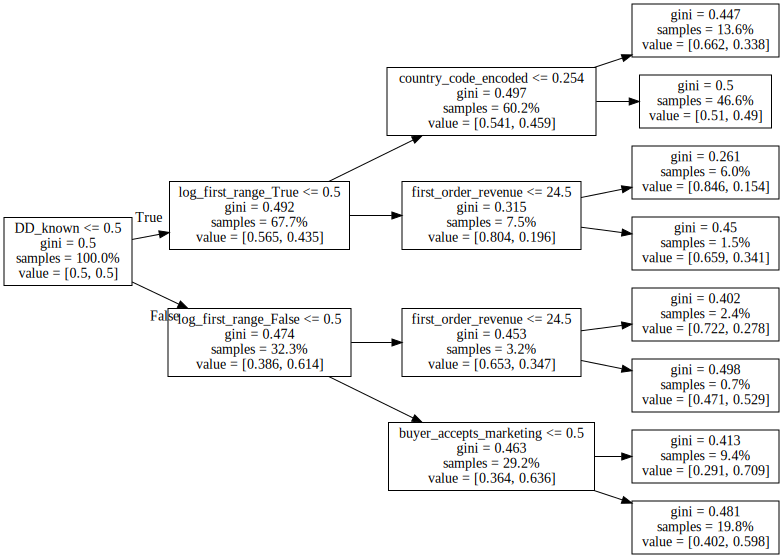

In [103]:
tree=DecisionTreeClassifier(random_state=42,class_weight="balanced", max_depth=3, criterion='gini',min_samples_leaf=2, min_samples_split= 50, splitter='best')
tree.fit(X_train , y_train)
export_graphviz(tree, out_file="tree.dot", feature_names=X_train.columns, proportion=True, rotate=True)
with open("tree.dot") as f:
    dot_graph = f.read()
s = Source.from_file("tree.dot")
s.view()
s

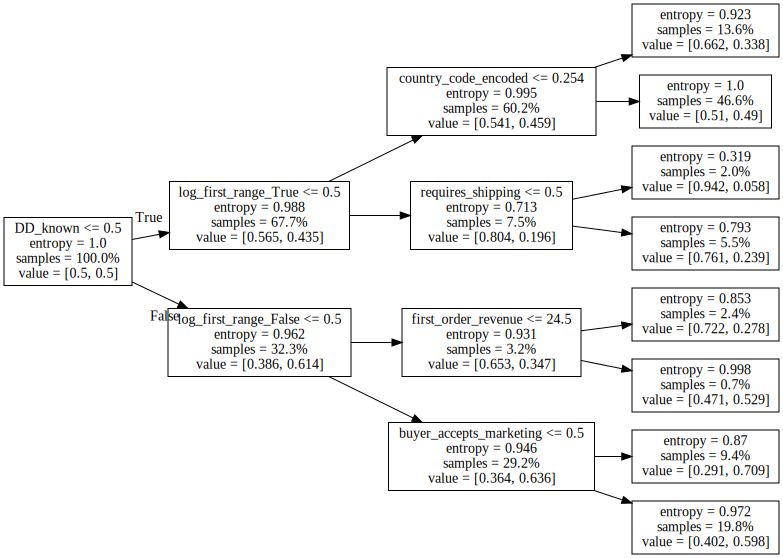

In [104]:
tree=DecisionTreeClassifier(random_state=42,class_weight="balanced", max_depth=3, criterion='entropy',min_samples_leaf=5, min_samples_split= 2, splitter='best')
tree.fit(X_train , y_train)
export_graphviz(tree, out_file="tree.dot", feature_names=X_train.columns, proportion=True, rotate=True)
with open("tree.dot") as f:
    dot_graph = f.read()
s = Source.from_file("tree.dot")
s.view()
s

### RandomForest


try for loop on RandomForest 
print test_score, train_score

In [105]:
from sklearn.ensemble import RandomForestClassifier

In [106]:
model = RandomForestClassifier(random_state=42,class_weight="balanced")
param_grid = {'n_estimators': [200,300,500,800],   # sets the number of decision trees to be used in the forest.
              'max_depth': [3,5],                  #Set the max depth of the tree
              'min_samples_leaf': [10,30],       #The minimum number of samples needed to create a leaf (decision) node
             'min_samples_split': [25,50,80]      #The minimum number of samples needed before a split (differentiation) is made in an internal node
             }

feat1= []
feat2 = []
feat3 =[]
feat4 =[]
f1 = []
test_f1=[]
train_f1=[]


for params in ParameterGrid(param_grid):
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_test_pred=model.predict(X_test)
    test_f1_score=metrics.f1_score(y_test, y_test_pred)
    y_train_pred= model.predict(X_train)
    train_f1_score=metrics.f1_score(y_train, y_train_pred)
    feat1.append(params['n_estimators'])
    feat2.append(params['max_depth'])
    feat3.append(params['min_samples_split'])
    feat4.append(params['min_samples_leaf'])
    test_f1.append(test_f1_score)
    train_f1.append(train_f1_score)
    f1.append(test_f1)
    print(params, test_f1_score,train_f1_score) 

{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 25, 'n_estimators': 200} 0.3314524936294139 0.46724432871708776
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 25, 'n_estimators': 300} 0.3323646930621141 0.4672656538722894
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 25, 'n_estimators': 500} 0.3331825992583884 0.468892955169259
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 25, 'n_estimators': 800} 0.3314586357039187 0.4667388341239386
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 200} 0.3314524936294139 0.46724432871708776
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 300} 0.3323646930621141 0.46726379704984744
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 500} 0.3331825992583884 0.468892955169259
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 800} 0.3314586357039187 0.4667388341239386

In [107]:
rf = pd.DataFrame({'n_estimators': feat1, 'max_depth': feat2,'min_samples_split':feat3,
                   'min_samples_leaf':feat4, 'test_f1_score':test_f1, 'train_f1_score':train_f1})

In [108]:
np.max(test_f1)

0.33327308874028555

In [109]:
rf.loc[rf.test_f1_score==np.max(test_f1)]

,n_estimators,max_depth,min_samples_split,min_samples_leaf,test_f1_score,train_f1_score
22,500,3,80,30,0.333273,0.467702


## 7.Evaluation and model selection 

In [110]:
classifiers = [
LogisticRegression(random_state=42,class_weight='balanced',penalty = 'l1',C= 0.0005, solver='liblinear'),
DecisionTreeClassifier(random_state=42,class_weight="balanced", max_depth=3, criterion='gini',min_samples_leaf=2, min_samples_split= 5, splitter='best'),
RandomForestClassifier(random_state=42,class_weight="balanced",max_depth=3, n_estimators=500,min_samples_leaf=30, min_samples_split=80)
]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_f1=metrics.f1_score(y_test, y_test_pred)
    train_f1=metrics.f1_score(y_train, model.predict(X_train))
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    accuracy= accuracy_score(y_test, y_test_pred)
    roc_auc_score = metrics.roc_auc_score(y_test, y_test_pred)

    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'test_f1_score':test_f1,
                                        'train_f1_score': train_f1,
                                        'precision':precision,
                                        'recall':recall,
                                        'accuracy':accuracy ,
                                        'roc_auc_score': roc_auc_score
                                        },ignore_index=True) #ignore_index=True
result_table 

,classifiers,accuracy,precision,recall,roc_auc_score,test_f1_score,train_f1_score
0,LogisticRegression,0.572383,0.248418,0.668489,0.609769,0.362228,0.450882
1,DecisionTreeClassifier,0.679268,0.267255,0.439563,0.586020,0.332406,0.407691
2,RandomForestClassifier,0.718257,0.292281,0.387639,0.589643,0.333273,0.467702


In [111]:
lg=LogisticRegression(random_state=42,class_weight='balanced',penalty = 'l1',C= 0.0005, solver='liblinear')
model= lg.fit(X_train, y_train)
print(model.coef_, model.intercept_)

[[-2.39645914e-01  5.78294125e-04  0.00000000e+00  0.00000000e+00
  -1.33016458e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.83755320e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.35688958e-01
  -1.34759791e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -7.75286508e-01]] [0.]


In [112]:
print('intercept:',model.intercept_ )

intercept: [0.]


In [113]:
model.coef_.tolist()

[[-0.23964591434517124,
  0.000578294125414281,
  0.0,
  0.0,
  -0.013301645775721588,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.5837553203763831,
  0.0,
  0.0,
  0.0,
  0.0,
  0.23568895791245878,
  -0.13475979096500143,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.7752865078114287]]

In [114]:
cof=pd.DataFrame(columns=['features','coefficients'])
cof['features']= X_train.columns.to_list()
cof['coefficients'] = model.coef_.T.tolist()
cof


,features,coefficients
0,buyer_accepts_marketing,[-0.23964591434517124]
1,first_order_revenue,[0.000578294125414281]
2,first_order_discount,[0.0]
3,requires_shipping,[0.0]
4,item_qty,[-0.013301645775721588]
5,unique_item,[0.0]
6,utm_content_known,[0.0]
7,landing_site_known,[0.0]
8,utm_term_known,[0.0]
9,utm_campaign_known,[0.0]
